In [2]:
import json
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)
import sys
sys.path.insert(0,'../')
from numpy import genfromtxt
import numpy as np
from pak.evaluation import MOTA
from cabbage.data.video import VideoData
from experiments import MOT16_Experiments, remove_negative_pairs
from time import time
from pak.datasets.MOT import MOT16
root = Settings['data_root']
mot16__ = MOT16(root)

X, Y_det, Y_gt = mot16__.get_train("MOT16-11", memmapped=True)

mot16 = MOT16_Experiments(root)

print("check:")
print(mot16.mot16_11_detections.shape)
print("")



__start = time()
result = genfromtxt('../build/RESULT_td.txt', delimiter=' ', 
                    dtype='uint32')
__end = time()
print('elapsed', __end - __start)
print('load results:', result.shape)



def extract_ids(result):
    #TODO: make this stuff better..
    
    candidates = []
    n = np.max(result[:,1])  # total number of nodes
    
    Nodes = [i for i in range(n+1)]
    
    
    for i, j, edge in result:
        assert(i < j)
        has_edge = edge == 0
        
        if has_edge:
            repres = Nodes[i]
            Nodes[j] = repres

    #print(Nodes)     
    return Nodes

__start = time()
Nodes = extract_ids(result)
__end = time()
print('elapsed', __end - __start)
print('finished extracting ids')

# translate to sensible id's
n_unique = len(np.unique(Nodes))
lookup = {}
for new,old in zip(list(range(n_unique)), np.unique(Nodes)):
    lookup[old] = new

print("Unique ids:", n_unique)
print("total nodes:", len(Nodes))

{'data_root': '/home/data',
 'deepmatch': '/home/deepmatching_1.2.2_c++/deepmatching-static',
 'graph_solver': '/home/cabbage/build/sample'}
/home/data/MOT16 found :)
MOT16: load memmapped file /home/data/MOT16/train/MOT16-11/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded
check:
(8125, 6)

elapsed 19.190031051635742
load results: (5070520, 3)
elapsed 11.660890340805054
finished extracting ids
Unique ids: 60
total nodes: 3185


In [3]:
from pak.post_processing import MOT
from cabbage.evaluation import MOTA_transform

h__, w__, _ = X[0].shape
#ALL_DETECTIONS = mot16.mot16_11_detections[0:len(Nodes)]  # as we do not need all frames..
ALL_DETECTIONS = remove_negative_pairs(
    mot16.mot16_11_true_detections_no_pid,
    w__, h__)

ALL_DETECTIONS = ALL_DETECTIONS[0:len(Nodes)]


Dt = []
for i, (pid, data) in enumerate(zip(Nodes, ALL_DETECTIONS)):
    frame, x, y, w, h, score = data
    Dt.append((frame, pid, x, y, w, h, score))
Dt = np.array(Dt)


print("before", Dt.shape)
Dt = MOT.remove_short_tracks(
    MOT.remove_duplicates(Dt, lambda x: x[6]),
    min_length=4)


print("after", Dt.shape)
Dt = Dt[:,0:6]



Gt = mot16.get_MOT16_11_gt_trajectories()
Gt = remove_negative_pairs(Gt, w__, h__, True)
vd = VideoData(Gt)
#Gt = vd.get_n_first_frames(50)

print("GT", Gt.shape)

threshold=0.5
result, info = MOTA.evaluate_aabb(Gt, Dt, threshold, info=True)


print("MOTA (aabb):", result)
print("\tinfo:", info)

threshold = 350

Gt_center = MOTA_transform.aabb_to_center_point(Gt)
Hy_center = MOTA_transform.aabb_to_center_point(Dt)
result, info = MOTA.evaluate(Gt_center, Hy_center, threshold, info=True)
print("\nMOTA (center):", result)
print("\t", info)

Gt_floor = MOTA_transform.aabb_to_floor_point(Gt)
Hy_floor = MOTA_transform.aabb_to_floor_point(Dt)
result, info = MOTA.evaluate(Gt_floor, Hy_floor, threshold, info=True)
print("\nMOTA (floor):", result)
print("\t", info)

before (3185, 7)
after (2687, 7)
GT (3189, 6)
MOTA (aabb): 0.841643148322
	info: {'FN': 503, 'FP': 1, 'IDSW': 1, 'GT': 3189}

MOTA (center): 0.841643148322
	 {'FN': 503, 'FP': 1, 'IDSW': 1, 'GT': 3189}

MOTA (floor): 0.841643148322
	 {'FN': 503, 'FP': 1, 'IDSW': 1, 'GT': 3189}


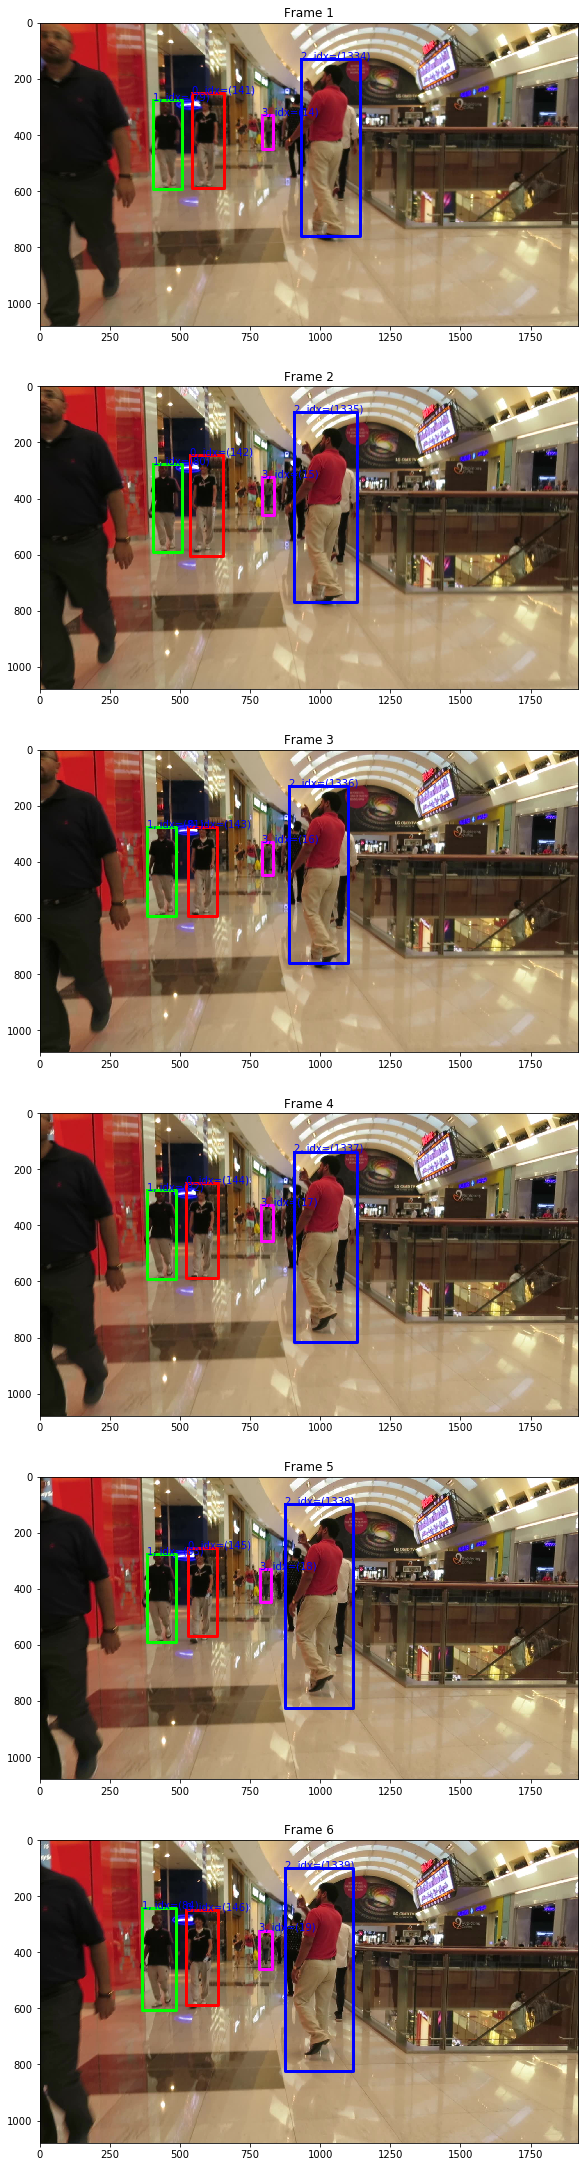

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from pak import utils
from cselect import color as cs

n_unique = len(np.unique(Nodes))
colors = cs.lincolor(n_unique, random_sat=True, random_val=True)
COLOR_LOOKUP = {}
for pid, color in zip(np.unique(Nodes), colors):
    COLOR_LOOKUP[str(pid)] = color
    
COLOR_LOOKUP = {
    "0": np.array((255, 0, 0)),
    "1": np.array((0, 255, 0)),
    "2": np.array((0, 0, 255)),
    "3": np.array((255, 0, 255)),
    "17": np.array([133, 133, 0])
}

frames = range(1, 7)

fig = plt.figure(figsize=(13,13*3))
_h = len(frames); _w = 1
for idx, f in enumerate(frames):
    ax = fig.add_subplot(_h,_w,idx+1)
    ax.imshow(X[f])
    for idx, (f_, pid, x, y, w, h) in enumerate(Dt):
        if f == f_:
            color = COLOR_LOOKUP[str(int(pid))]
            bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
            ax.text(x, y, str(int(pid)) + ", idx=(" + str(idx) + ")", color='blue')
            ax.plot(bbX, bbY, linewidth=3, color=color/255)
            ax.set_title('Frame ' + str(f))
        

plt.show()